In [1]:
!pip install tensorflow.io[tensorflow]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 1.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 28.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 3.0.4
    Uninstalling keras-3.0.4:
      Successfully uninstalled keras-3.0.4
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.2.0
    Uninstalling google-auth-oauthlib-1.2.0:
      Successfully uninstalled google-auth-oauthlib-1.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.1

In [2]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

2024-02-06 10:56:52.233829: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 10:56:52.233891: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 10:56:52.233943: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
url = 'https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing'
od.download(url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  ebadsayed


Your Kaggle Key:

  ································


100%|██████████| 604M/604M [00:03<00:00, 205MB/s] 


In [5]:
os.rename('z-by-hp-unlocked-challenge-3-signal-processing', 'data')

CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [6]:
def load_wav_16k_mono(filename):
  #load encoded wav file
  file_contents = tf.io.read_file(filename)
  #decode wav (tensors by channels)
  wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
  #Remove trailing axis
  wav = tf.squeeze(wav, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)
  #goes from 44100 Hz to 1600 Hz - amplitude of the audio signal
  wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
  return wav

In [7]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

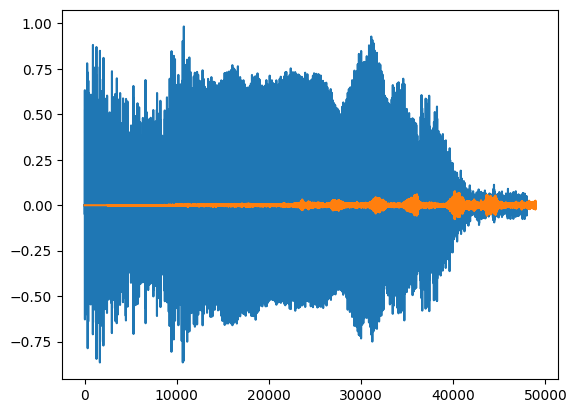

In [8]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [9]:
POS = os.path.join('data','Parsed_Capuchinbird_Clips/*.wav')
NEG = os.path.join('data','Parsed_Not_Capuchinbird_Clips/*.wav')

In [10]:
pos = tf.data.Dataset.list_files(POS)
neg = tf.data.Dataset.list_files(NEG)

In [11]:
positive = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negative = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positive.concatenate(negative)

In [12]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
  tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
  lengths.append(len(tensor_wave))

In [13]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [14]:
filepath, label = positive.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [15]:
spectrogram, label = preprocess(filepath, label)

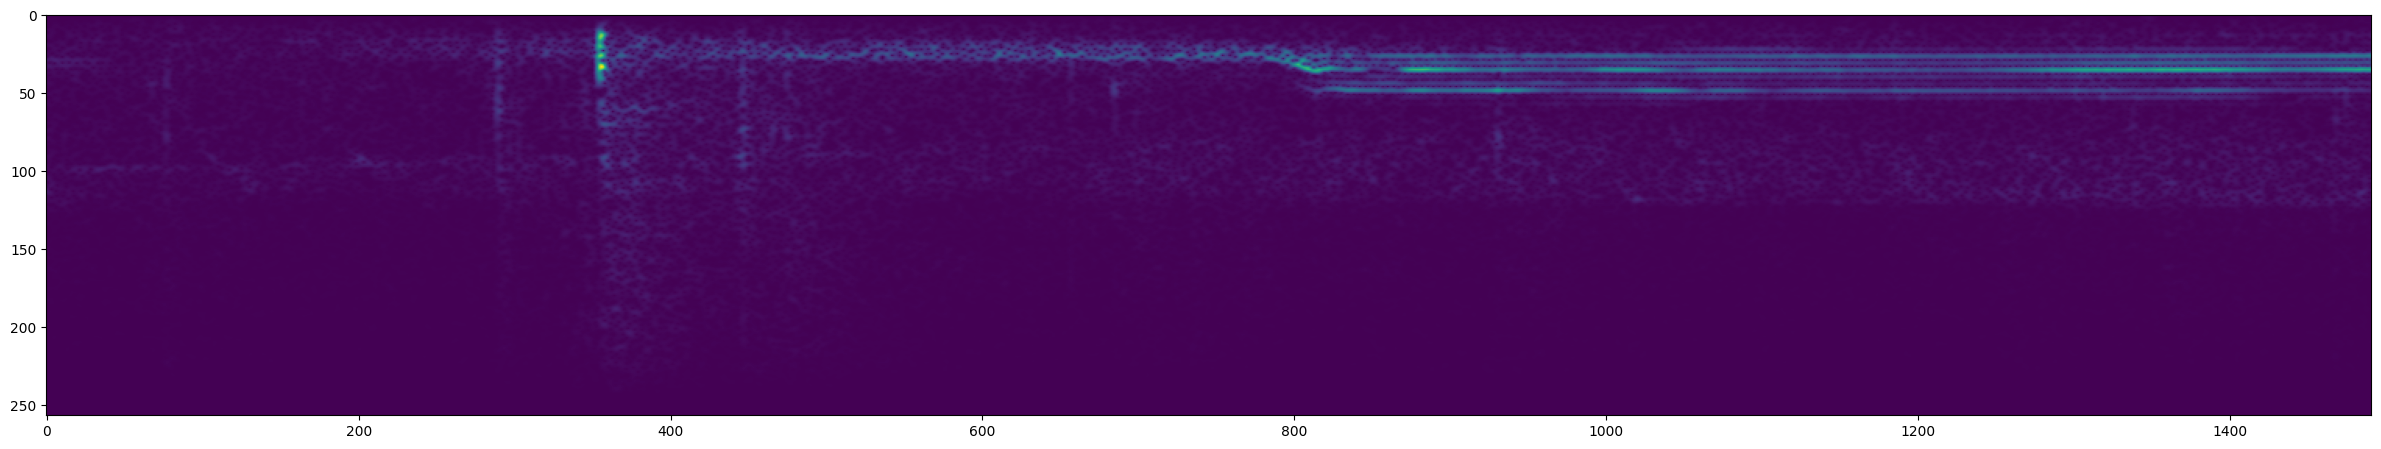

In [16]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [17]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [18]:
train = data.take(36)
test = data.skip(36).take(15)

In [19]:
samples, labels = train.as_numpy_iterator().next()

In [20]:
samples.shape

(16, 1491, 257, 1)

In [21]:
labels.shape

(16,)

In [22]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770482865 (2.87 GB)
Trainable params: 770482865 (2.87 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
history = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 151s 4s/step - loss: 14.4047 - recall: 0.8411 - precision: 0.7216 - val_loss: 0.4177 - val_recall: 0.9848 - val_precision: 0.9420
Epoch 2/4
36/36 [==============================] - 145s 4s/step - loss: 0.3350 - recall: 0.9404 - precision: 0.9595 - val_loss: 0.0803 - val_recall: 0.9516 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 144s 4s/step - loss: 0.1059 - recall: 0.9872 - precision: 0.9625 - val_loss: 0.0010 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 144s 4s/step - loss: 0.0151 - recall: 0.9867 - precision: 0.9933 - val_loss: 0.0060 - val_recall: 1.0000 - val_precision: 0.9844


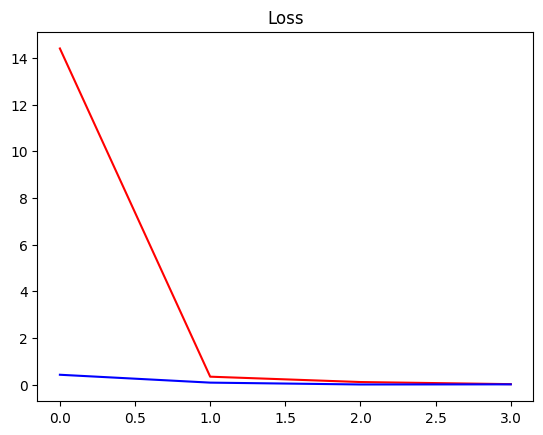

In [26]:
plt.title('Loss')
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.show()

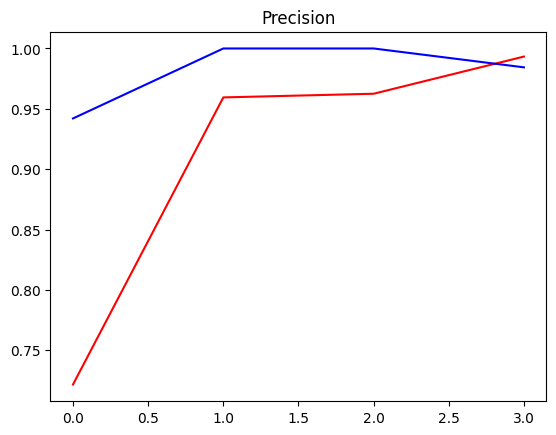

In [28]:
plt.title('Precision')
plt.plot(history.history['precision'], 'r')
plt.plot(history.history['val_precision'], 'b')
plt.show()

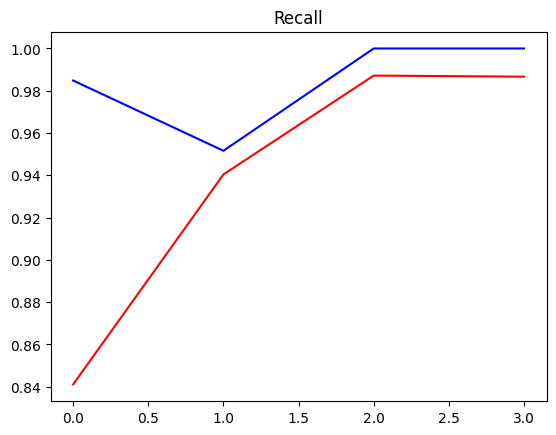

In [29]:
plt.title('Recall')
plt.plot(history.history['recall'], 'r')
plt.plot(history.history['val_recall'], 'b')
plt.show()

In [30]:
def load_mp3_16k_mono(filename):
    """ Load an audio file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

wav = load_mp3_16k_mono(mp3)

audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

samples, index = audio_slices.as_numpy_iterator().next()

In [31]:
# Build Function to Convert Clips into Windowed Spectrograms
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

3/3 [==============================] - 3s 747ms/step


In [33]:
from itertools import groupby

In [34]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [35]:
calls

7.2006035

In [36]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

1/1 [==============================] - 1s 1s/step


In [37]:
results

{'recording_05.mp3': array([[0.00879322],
        [0.00141897],
        [0.00042336],
        [0.00295288],
        [0.00175656],
        [0.00097706],
        [0.0014885 ],
        [0.0041502 ],
        [0.00097094],
        [0.00195687],
        [0.00172117],
        [0.0067419 ],
        [0.01041183],
        [0.00111167],
        [0.01303573],
        [0.00222598],
        [0.00303162],
        [0.00181592],
        [0.00085078],
        [0.001948  ],
        [0.00381989],
        [0.00104752],
        [0.00232799],
        [0.00191522],
        [0.00531992],
        [0.00724156],
        [0.00128223],
        [0.01391266],
        [0.00140598],
        [0.00201744],
        [0.00172367],
        [0.0007742 ],
        [0.00259712],
        [0.00317775],
        [0.00180577],
        [0.00309576],
        [0.00164981],
        [0.0061801 ],
        [0.01220699],
        [0.00219078],
        [0.01461035],
        [0.00149155],
        [0.00327813],
        [0.00152862],
        [0.0

In [38]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_05.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_65.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_76.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_80.mp3': [0,
  0,
  0,
  

In [39]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_05.mp3': 0,
 'recording_65.mp3': 4,
 'recording_76.mp3': 0,
 'recording_80.mp3': 1,
 'recording_38.mp3': 9,
 'recording_62.mp3': 0,
 'recording_15.mp3': 2,
 'recording_28.mp3': 15,
 'recording_53.mp3': 0,
 'recording_61.mp3': 13,
 'recording_32.mp3': 2,
 'recording_23.mp3': 14,
 'recording_60.mp3': 5,
 'recording_51.mp3': 6,
 'recording_25.mp3': 15,
 'recording_56.mp3': 16,
 'recording_75.mp3': 1,
 'recording_24.mp3': 0,
 'recording_74.mp3': 0,
 'recording_98.mp3': 21,
 'recording_36.mp3': 0,
 'recording_45.mp3': 6,
 'recording_37.mp3': 5,
 'recording_99.mp3': 5,
 'recording_73.mp3': 0,
 'recording_63.mp3': 14,
 'recording_18.mp3': 2,
 'recording_66.mp3': 0,
 'recording_55.mp3': 0,
 'recording_42.mp3': 0,
 'recording_97.mp3': 4,
 'recording_49.mp3': 0,
 'recording_58.mp3': 0,
 'recording_71.mp3': 16,
 'recording_67.mp3': 0,
 'recording_70.mp3': 3,
 'recording_78.mp3': 13,
 'recording_19.mp3': 1,
 'recording_27.mp3': 0,
 'recording_92.mp3': 13,
 'recording_06.mp3': 13,
 'rec

In [40]:
import csv

with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])